In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.pylab import rcParams
import xgboost as xgb
from xgboost import plot_importance
import warnings

import time
import datetime
warnings.filterwarnings('ignore')
path = "D:/program/program1/Cargo_forecast/dot_data_all/"

### 加载数据

In [3]:
dot_num1 = pd.read_csv(path + 'cst1.csv', header = None, names = ['order_date', 'dot', 'company', 'order_num'])
dot_num2 = pd.read_csv(path + 'cst2.csv', header = None, names = ['order_date', 'dot', 'company', 'order_num'])

In [4]:
dot_info = pd.read_csv(path + 'dot_1.csv', header = None, names = ['dot', 'check_date', 'dot_type', 'city_code', 'area', 'province', 'city', 'district', 'town', 'village'])

In [5]:
dot_info.head()

,dot,check_date,dot_type,city_code,area,province,city,district,town,village
0,清江新下塘点部,2018-09-13,大点部,577,华东,浙江省,温州市,乐清市,城东街道,新下塘村
1,香洲洪湾点部,2018-08-13,大点部,756,华南,广东省,珠海市,香洲区,南屏镇,洪湾社区
2,贵阳三甫点部,2018-05-15,大点部,851,华北,贵州省,贵阳市,观山湖区,金华镇,三甫村
3,镇江大港点部,2018-05-10,大点部,511,华东,江苏省,镇江市,镇江新区,大路镇,大路村
4,三水竹山点部,2018-06-06,大点部,757,华南,广东省,佛山市,三水区,乐平镇,竹山村


In [6]:
dot_num = pd.concat([dot_num1, dot_num2], ignore_index = True)
dot_num['order_date'] = [str(x)[0:4] +'-'+ str(x)[4:6] +'-'+ str(x)[6:] for x in dot_num['order_date']]
dot_num['order_date'] = pd.to_datetime(dot_num['order_date'])

In [7]:
len(dot_num['dot'].unique())

7345

In [8]:
len(dot_info['dot'].unique())

2642

### 筛选点部

In [9]:
dot_data_tmp = dot_num[dot_num['dot'].isin(dot_info['dot'])]

In [10]:
dot_data_tmp.sort_values(by = 'order_num', ascending = False).head()

,order_date,dot,company,order_num
5977844,2018-11-12,相城洋沟娄点部,苏州怡阳,9983
7001755,2018-09-09,青浦纪王点部,苏州天阳蟹业,9316
7831388,2018-09-08,青浦纪王点部,苏州天阳蟹业,8773
8552765,2018-11-11,相城洋沟娄点部,苏州怡阳,8270
5280879,2018-09-23,相城洋沟娄点部,苏州怡阳,7712


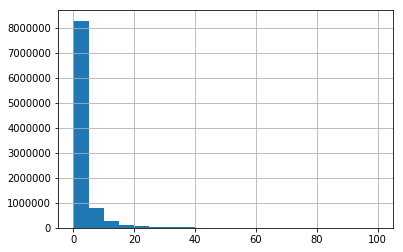

In [129]:
dot_data_tmp['order_num'].hist(bins = 20, range = (0,100))

In [124]:
len(dot_data_tmp[dot_data_tmp['order_num'] >40])/len(dot_data_tmp)

0.005837943652408437

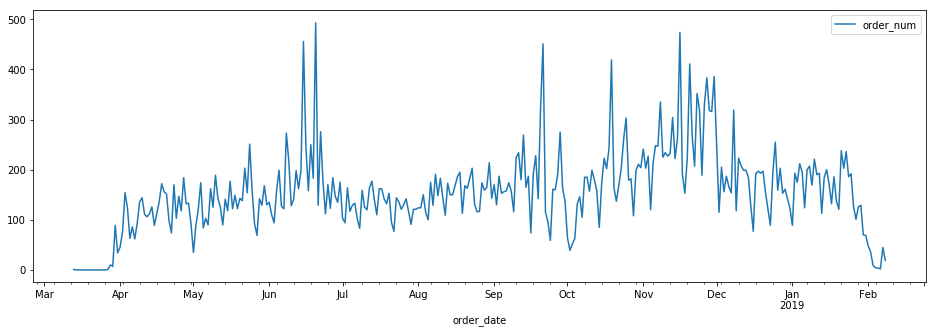

In [139]:
dot_data_tmp.index = dot_data_tmp['order_date']
dot_data_tmp.loc[dot_data_tmp['dot'] == '石壁会江点部', ['order_num']].resample('D').sum().plot(figsize = (16,5))

In [ ]:
# a1 = dot_data_tmp.loc[dot_data_tmp['dot'] == '相城洋沟娄点部', ['order_num']].resample('D').sum()
# a1.describe()

In [9]:
dot_data_tmp.loc[dot_data_tmp['order_num'] > 40, ['order_num']] = 1

In [141]:
dot_data_tmp = dot_data_tmp.drop(['company'], axis = 1)

In [142]:
dot_groupby = dot_data_tmp.groupby(['dot', 'order_date']).sum()
dot_groupby.reset_index(inplace = True)

In [143]:
dot_groupby.sort_values(by = 'order_date', inplace = True)
dot_groupby.tail()

,dot,order_date,order_num
341710,晋江华科点部,2019-02-08,11
28328,临平章家河点部,2019-02-08,6
341393,晋江华山点部,2019-02-08,18
535884,白云太和点部,2019-02-08,10
600331,绍兴柏舍点部,2019-02-08,19


In [13]:
dot_preprocessing = pd.DataFrame()
for i, dot in enumerate(dot_groupby['dot'].unique()):
    one_dot = dot_groupby.loc[dot_groupby['dot'] == dot]
    check_time = dot_info.loc[dot_info['dot'] == dot, 'check_date']
    one_dot = one_dot[one_dot['order_date'] > check_time.iloc[0]]
    if len(one_dot) == 0:
        continue
    num_median = np.median(one_dot['order_num'])
    
    one_dot.index = one_dot['order_date']
    one_dot_resample = one_dot.resample('D').asfreq()
    one_dot_resample.drop(['order_date'], axis = 1, inplace = True)
    one_dot_resample.reset_index(inplace = True)
    one_dot_resample['dot'].fillna(dot, inplace = True)
    one_dot_resample['order_num'].fillna(num_median, inplace = True)
    one_dot_resample['dot_id'] = i + 1

    dot_preprocessing = pd.concat([dot_preprocessing, one_dot_resample], axis = 0,ignore_index = True)

In [14]:
dot_preprocessing.head()

,order_date,dot,order_num,dot_id
0,2017-01-14,桐乡凤鸣点部,58.0,1
1,2017-01-15,桐乡凤鸣点部,54.0,1
2,2017-01-16,桐乡凤鸣点部,67.0,1
3,2017-01-17,桐乡凤鸣点部,70.0,1
4,2017-01-18,桐乡凤鸣点部,67.0,1


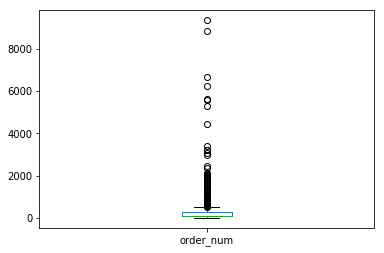

In [57]:
dot_preprocessing.loc[dot_preprocessing['dot'] == '青浦纪王点部',['order_num']].plot.box()  # 青浦纪王点部

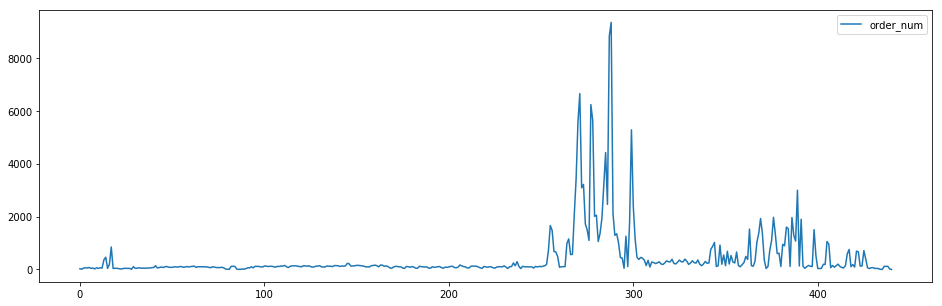

In [63]:
dot_preprocessing.loc[dot_preprocessing['dot'] == '青浦纪王点部', ['order_num']].reset_index(drop=True).plot(figsize = (16, 5))

In [15]:
dot_prep = dot_preprocessing.copy()
dot_prep['order_num'] = np.log1p(dot_prep['order_num'])
dot_prep.sort_values(by = ['order_date'], inplace = True)
dot_prep.head()

,order_date,dot,order_num,dot_id
0,2017-01-14,桐乡凤鸣点部,4.077537,1
108416,2017-01-14,扬州槐泗点部,3.931826,181
107668,2017-01-14,青岛平度点部,1.386294,180
106918,2017-01-14,南昌高新点部,1.609438,179
106169,2017-01-14,长春二道点部,0.693147,178


In [16]:
dot_data = pd.merge(dot_info, dot_prep, how = 'left', on = 'dot')
dot_data.head()

,dot,check_date,dot_type,city_code,area,province,city,district,town,village,order_date,order_num,dot_id
0,清江新下塘点部,2018-09-13,大点部,577,华东,浙江省,温州市,乐清市,城东街道,新下塘村,2018-09-14,3.258097,1026.0
1,清江新下塘点部,2018-09-13,大点部,577,华东,浙江省,温州市,乐清市,城东街道,新下塘村,2018-09-15,3.332205,1026.0
2,清江新下塘点部,2018-09-13,大点部,577,华东,浙江省,温州市,乐清市,城东街道,新下塘村,2018-09-16,2.397895,1026.0
3,清江新下塘点部,2018-09-13,大点部,577,华东,浙江省,温州市,乐清市,城东街道,新下塘村,2018-09-17,2.833213,1026.0
4,清江新下塘点部,2018-09-13,大点部,577,华东,浙江省,温州市,乐清市,城东街道,新下塘村,2018-09-18,3.401197,1026.0


In [17]:
dot_data.loc[dot_data['city'].isnull(), ['city']] = dot_data.loc[dot_data['city'].isnull(), ['province']].values
dot_data.loc[dot_data['district'].isnull(), ['district']] = dot_data.loc[dot_data['district'].isnull(), ['city']].values

In [18]:
dot_data.dropna(axis = 0, inplace = True)
dot_data.sort_values(by = 'order_date', ascending = True, inplace = True)

In [19]:
len(dot_data['dot'].unique())

2411

In [20]:
def time_feature(data):
    # 时间
    dot_prep_1 = data.copy()
    
    dot_prep_1['year'] = dot_prep_1.order_date.dt.year
    dot_prep_1['month'] = dot_prep_1.order_date.dt.month
    dot_prep_1['day'] = dot_prep_1.order_date.dt.day
    dot_prep_1['dayofweek'] = dot_prep_1.order_date.dt.dayofweek
    dot_prep_1['dayofyear'] = dot_prep_1.order_date.dt.dayofyear
    dot_prep_1['weekofyear'] = dot_prep_1.order_date.dt.weekofyear
    
    weekofsun = pd.date_range('2017-12-01', periods = round(len(dot_prep_1['order_date'].unique())/7), freq = 'W-SUN')
    dot_prep_1['weekofsun'] = 0
    dot_prep_1.loc[dot_prep_1['order_date'].isin(weekofsun), ['weekofsun']] = 1
    
    dot_prep_1['holidays'] = 0
    dot_prep_1.loc[dot_prep_1['order_date'].isin(
    pd.to_datetime(['2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01', '2017-01-23','2017-01-24', '2017-01-25',
                    '2017-01-26','2017-01-27', '2017-01-28', '2017-01-29', '2017-01-30', '2017-01-31', '2017-02-01', '2017-02-02',
                    '2017-02-03','2017-02-04','2018-02-12', '2018-02-13',  '2018-02-14','2018-02-15', '2018-02-16', '2018-02-17', 
                    '2018-02-18', '2018-02-19', '2018-02-20', '2018-02-21','2018-02-22','2018-02-23', '2018-02-24', '2019-02-01', 
                    '2019-02-02', '2019-02-03','2019-02-04', '2019-02-05', '2019-02-06', '2019-02-07', '2019-02-08', '2019-02-09', 
                    '2019-02-10', '2019-02-11', '2019-02-12', '2019-02-13','2017-04-02', '2017-04-03', '2017-04-04', '2018-04-05', 
                    '2018-04-06', '2018-04-07', '2019-04-05', '2019-04-06', '2019-04-07','2017-05-01', '2017-05-02', '2017-05-03', 
                    '2018-05-01', '2018-05-02', '2018-05-03', '2019-05-01', '2019-05-02', '2019-05-03','2017-05-30', '2018-06-18', 
                    '2019-06-07', '2017-10-04', '2018-09-22', '2018-09-23', '2018-09-24', '2019-09-13', '2019-09-14', '2019-09-15',
                    '2017-10-01', '2017-10-02', '2017-10-03',  '2017-10-04', '2017-10-05', '2017-10-06', '2017-10-07','2018-10-01',
                    '2018-10-02', '2018-10-03', '2018-10-04', '2018-10-05', '2018-10-06', '2018-10-07', '2019-10-01', '2019-10-02', 
                    '2019-10-03', '2019-10-04', '2019-10-05', '2019-10-06', '2019-10-07'])), ['holidays']] = 1
    
    return dot_prep_1

def create_feature(data, all_dot):
    dot_prep_1 = time_feature(data)
    dot_prep_ts = data.copy()
    dot_prep_ts.index = pd.to_datetime(dot_prep_ts['order_date'])
    
    dot_prep_2 = pd.DataFrame()
    dot_prep_3 = pd.DataFrame()
    for dot in all_dot:
        dot_ts = dot_prep_ts.loc[dot_prep_ts['dot'] == dot, ['order_num']]
        dot_ts.sort_index(ascending = True, inplace = True)
        # lagging
        lagging = pd.concat([dot_ts.shift(1), dot_ts.shift(2), dot_ts.shift(3), dot_ts.shift(4), dot_ts.shift(5), dot_ts.shift(6), dot_ts.shift(7)], axis = 1)
        lagging.columns = ['lagging1', 'lagging2', 'lagging3', 'lagging4', 'lagging5', 'lagging6', 'lagging7']
        lagging['dot'] = dot
        lagging['order_date'] = dot_ts.index
        lagging.dropna(axis = 0, inplace = True)
        dot_prep_2 = pd.concat([dot_prep_2, lagging], axis = 0)
        
        # rolling
        rolling = pd.concat([dot_ts.rolling(window = 3).mean(), dot_ts.rolling(window = 5).mean(), dot_ts.rolling(window = 7).mean()], axis = 1)
        rolling.index = rolling.index + pd.DateOffset(days = 1)
        rolling.columns = ['rolling3', 'rolling5', 'rolling7']
        rolling['dot'] = dot
        rolling['order_date'] = rolling.index
        rolling.dropna(axis = 0, inplace = True)
        dot_prep_3 = pd.concat([dot_prep_3, rolling], axis = 0)
    dot_prep_2.reset_index(drop = True, inplace = True)
    dot_prep_3.reset_index(drop = True, inplace = True)
    
    # merge
    dot_prep_result_tmp = pd.merge(dot_prep_1, dot_prep_2, how = 'right', on = ['dot', 'order_date'])
    dot_prep_result = pd.merge(dot_prep_result_tmp, dot_prep_3, how = 'left', on = ['dot', 'order_date'])
    dot_prep_result.sort_values(by = 'order_date', ascending = True, inplace = True)
#     dot_prep_result.drop(['dot', 'order_date'], axis = 1, inplace = True)
    
    return dot_prep_result

In [21]:
print("START: ",datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
all_dot = dot_data['dot'].unique()
dot_prep_feature = create_feature(dot_data, all_dot)
print("END: ",datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

START:  2019-02-25 18:00:40
END:  2019-02-25 18:04:24


dot_prep_feature.to_csv(path + "dot_prep_feature.csv", encoding = 'GBK')

In [22]:
dot_res_tmp = dot_prep_feature.drop(['check_date', 'city', 'district', 'town', 'village'], axis = 1)
dot_res_tmp.head()

,dot,dot_type,city_code,area,province,order_date,order_num,dot_id,year,month,...,lagging1,lagging2,lagging3,lagging4,lagging5,lagging6,lagging7,rolling3,rolling5,rolling7
0,闵行吴泾点部,小点部,21,华东,上海,2017-01-21,1.386294,222.0,2017,1,...,1.945910,3.295837,2.397895,2.772589,2.995732,0.693147,2.484907,2.546547,2.681593,2.369431
100,昆明机场点部,航空组,871,华北,云南省,2017-01-21,1.791759,78.0,2017,1,...,1.386294,0.693147,1.609438,1.098612,2.079442,0.693147,0.693147,1.229626,1.373387,1.179033
99,沙井和一点部,大点部,755,华南,广东省,2017-01-21,4.262680,15.0,2017,1,...,4.852030,5.351858,4.941642,5.049856,5.262690,4.394449,4.890349,5.048510,5.091615,4.963268
98,济南高新点部,大点部,531,华北,山东省,2017-01-21,1.386294,240.0,2017,1,...,2.397895,1.791759,1.609438,1.945910,1.791759,0.693147,1.791759,1.933031,1.907352,1.717381
97,园区亭东点部,大点部,512,华东,江苏省,2017-01-21,2.397895,199.0,2017,1,...,3.555348,3.663562,3.496508,3.496508,3.465736,1.609438,2.890372,3.571806,3.535532,3.168210


In [23]:
# 统计特征
dot_prep_sta = dot_res_tmp.copy()
dot_prep_dayofweek = dot_prep_sta.groupby(['dot', 'dayofweek'])['order_num'].agg([('week_mean', np.mean), ('week_median', np.median), ('week_min', np.min), ('week_max', np.max), ('week_std', np.std)]).reset_index()
dot_prep_day = dot_prep_sta.groupby(['dot', 'day'])['order_num'].agg([('day_mean', np.mean), ('day_median', np.median), ('day_min', np.min), ('day_max', np.max), ('day_std', np.std)]).reset_index()

dot_prep_tmp = pd.merge(dot_prep_sta, dot_prep_dayofweek, on = ['dot', 'dayofweek'], how = 'left')
dot_prep_stas = pd.merge(dot_prep_tmp, dot_prep_day, on = ['dot', 'day'], how = 'left')

In [24]:
dot_res = pd.concat([dot_prep_stas, pd.get_dummies(dot_prep_stas['dot_type']), pd.get_dummies(dot_prep_stas['area']), pd.get_dummies(dot_prep_stas['province'])], axis = 1)
dot_res.drop(['dot_type', 'area', 'province'], axis = 1, inplace = True)
dot_res.head()

,dot,city_code,order_date,order_num,dot_id,year,month,day,dayofweek,dayofyear,...,海南省,湖北省,湖南省,甘肃省,福建省,贵州省,辽宁省,重庆,陕西省,黑龙江省
0,闵行吴泾点部,21,2017-01-21,1.386294,222.0,2017,1,21,5,21,...,0,0,0,0,0,0,0,0,0,0
1,昆明机场点部,871,2017-01-21,1.791759,78.0,2017,1,21,5,21,...,0,0,0,0,0,0,0,0,0,0
2,沙井和一点部,755,2017-01-21,4.262680,15.0,2017,1,21,5,21,...,0,0,0,0,0,0,0,0,0,0
3,济南高新点部,531,2017-01-21,1.386294,240.0,2017,1,21,5,21,...,0,0,0,0,0,0,0,0,0,0
4,园区亭东点部,512,2017-01-21,2.397895,199.0,2017,1,21,5,21,...,0,0,0,0,0,0,0,0,0,0


In [25]:
dot_res.columns

Index(['dot', 'city_code', 'order_date', 'order_num', 'dot_id', 'year',
       'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'weekofsun',
       'holidays', 'lagging1', 'lagging2', 'lagging3', 'lagging4', 'lagging5',
       'lagging6', 'lagging7', 'rolling3', 'rolling5', 'rolling7', 'week_mean',
       'week_median', 'week_min', 'week_max', 'week_std', 'day_mean',
       'day_median', 'day_min', 'day_max', 'day_std', '二级中转场', '大点部', '小点部',
       '航空组', '虚拟点部', '京津冀', '华东', '华北', '华南', '上海', '云南省', '内蒙古', '北京', '吉林省',
       '四川省', '天津', '安徽省', '山东省', '山西省', '广东省', '广西', '新疆', '江苏省', '江西省',
       '河北省', '河南省', '浙江省', '海南省', '湖北省', '湖南省', '甘肃省', '福建省', '贵州省', '辽宁省',
       '重庆', '陕西省', '黑龙江省'],
      dtype='object')

dot_res.to_csv(path + "dot_res.csv", encoding = 'GBK')

In [ ]:
dot_res = pd.read_csv(path + "dot_res.csv", encoding = 'GBK')

In [ ]:
dot_train = dot_res[: -(30 * 2407)]
dot_test = dot_res[-(30 * 2407) :]

In [ ]:
dot_xtrain = dot_train.drop(['order_num'], axis = 1)
dot_ytrain = dot_train['order_num']
dot_xtest = dot_test.drop(['order_num'], axis = 1)
dot_ytest = dot_test['order_num']

In [ ]:
def RMSE(y_test, y_pred):
    return np.sqrt(np.sum((y_test - y_pred) ** 2)/len(y_test))

def MAE(y_test, y_pred):
    return np.sum(np.abs(y_test - y_pred))/len(y_test)

In [ ]:
def xgboost_model(x_train, y_train):
    params = {
        "learning_rate": 0.01,
        "n_estimators": 3300,
        "max_depth": 5,
        "min_child_weight": 3,
        "gamma": 0.5,
        "subsample": 0.9,
        "colsample_bytree": 0.8,
        "silent": 1,
        "reg_alpha" : 0.05,
        "reg_lambda" : 0.05,
        "seed": 21
    }
    print("train_start : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    gbm = xgb.XGBRegressor(**params)
    gbm.fit(x_train.drop(['dot', 'order_date'], axis = 1), y_train)
    print("train_end : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    
    for column, importance in zip(x_train.drop(['dot', 'order_date'], axis = 1).columns, gbm.feature_importances_):
        print(column, '\t', importance)
    # plot_importance(gbm)
    # plt.savefig(path + "feature_importance.png")
    
    return gbm

In [ ]:
gbm = xgboost_model(dot_xtrain, dot_ytrain)

### dump model

import pickle fw = open(path + "gbm.txt", 'wb') pickle.dump(gbm, fw)

### load model

import pickle
rw = open(path + 'gbm.txt', 'rb')
gbm = pickle.load(rw)

### 预测方式1

In [ ]:
def xgb_predict(gbm, x_test, y_test, path):
    # 验证
    print("predict_start : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    y_pre = gbm.predict(x_test.drop(['dot', 'order_date'], axis = 1))
    print("predict_end : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    result = pd.DataFrame({'dot' : x_test['dot'], 'order_date' : x_test['order_date'], 'y_test' : np.expm1(y_test), 'y_pre' : np.expm1(y_pre)})
    result['RMSE'] = RMSE(np.expm1(y_test), np.expm1(y_pre))
    result['MAE'] = MAE(np.expm1(y_test), np.expm1(y_pre))
    print("MAE : ", MAE(np.expm1(y_test), np.expm1(y_pre)), " RMSE : ", RMSE(np.expm1(y_test), np.expm1(y_pre)))
#     result = pd.DataFrame({'dot' : x_test['dot'], 'order_date' : x_test['order_date'], 'y_test' : y_test, 'y_pre' : y_pre})
#     result['RMSE'] = RMSE(y_test, y_pre)
#     result['MAE'] = MAE(y_test, y_pre)
#     print("MAE : ", MAE(y_test, y_pre), " RMSE : ", RMSE(y_test, y_pre))
    
    result.to_csv(path + "dot_result.csv", encoding = 'GBK', index = False)
    return result

In [ ]:
result = xgb_predict(gbm, dot_xtest, dot_ytest, path)

In [ ]:
plt.rcParams['font.sans-serif']=['SimHei']
col_1 = ['y_test','y_pre']
L = np.random.randint( low = 0, high = 2411, size = 3 )
for i in L:
    s1 = pd.DataFrame(result[result['dot'] == result['dot'].unique()[i]], columns = col_1)
    s1.plot(title = 'dot {}'.format(result['dot'].unique()[i]), figsize = (8,4))

### 预测方式2

In [ ]:
def pre_feature(data, dot_name):
    x_test_tmp = pd.DataFrame()
    rolling_tmp = pd.DataFrame()
    for dot in dot_name:
        # lagging
        dot_test = data.loc[data['dot'] == dot]
        dot_test_ts = dot_test.copy()
        dot_test['lagging7'] = dot_test['lagging6']
        dot_test['lagging6'] = dot_test['lagging5']
        dot_test['lagging5'] = dot_test['lagging4']
        dot_test['lagging4'] = dot_test['lagging3']
        dot_test['lagging3'] = dot_test['lagging2']
        dot_test['lagging2'] = dot_test['lagging1']
        dot_test['lagging1'] = dot_test['order_num']

        x_test_tmp = pd.concat([x_test_tmp, dot_test])

        # rolling
        dot_test_ts.index = pd.to_datetime(dot_test_ts['order_date'])
        num_ts = dot_test_ts.loc[dot_test_ts['dot'] == dot, ['order_num']]
        rolling = pd.concat([num_ts.rolling(window = 3).mean(), num_ts.rolling(window = 5).mean(), num_ts.rolling(window = 7).mean()], axis = 1)
    #     rolling.index = rolling.index + pd.DateOffset(days = 1)
        rolling.columns = ['rolling3', 'rolling5', 'rolling7']
        rolling['dot'] = dot
        rolling['order_date'] = rolling.index
        rolling_tmp = pd.concat([rolling_tmp, rolling])

    x_test = pd.merge(x_test_tmp.drop(['rolling3', 'rolling5', 'rolling7'], axis = 1), rolling_tmp, how = 'left', on = ['dot', 'order_date'])
    x_test['order_date'] = x_test['order_date'] + pd.DateOffset(days = 1)
    x_test.dropna(axis = 0, inplace = True)
    
    return x_test

In [ ]:
print("START : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
result_to_csv = pd.DataFrame()
pre_date = dot_train['order_date'].max() + pd.DateOffset(months = -1)
org_test = dot_train[dot_train['order_date'] > pre_date]
feature = ['dot', 'city_code', 'order_date', 'dot_id', 'lagging1', 'lagging2', 'lagging3', 'lagging4', 'lagging5',
       'lagging6', 'lagging7', 'rolling3', 'rolling5', 'rolling7', 'week_mean',
       'week_median', 'week_min', 'week_max', 'week_std', 'day_mean',
       'day_median', 'day_min', 'day_max', 'day_std', '二级中转场', '大点部', '小点部',
       '航空组', '虚拟点部', '京津冀', '华东', '华北', '华南', '上海', '云南省', '内蒙古', '北京', '吉林省',
       '四川省', '天津', '安徽省', '山东省', '山西省', '广东省', '广西', '新疆', '江苏省', '江西省',
       '河北省', '河南省', '浙江省', '海南省', '湖北省', '湖南省', '甘肃省', '福建省', '贵州省', '辽宁省',
       '重庆', '陕西省', '黑龙江省']
feature_num = ['dot', 'city_code', 'order_date', 'dot_id', 'year',
       'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'weekofsun',
       'holidays', 'lagging1', 'lagging2', 'lagging3', 'lagging4', 'lagging5',
       'lagging6', 'lagging7', 'rolling3', 'rolling5', 'rolling7', 'week_mean',
       'week_median', 'week_min', 'week_max', 'week_std', 'day_mean',
       'day_median', 'day_min', 'day_max', 'day_std', '二级中转场', '大点部', '小点部',
       '航空组', '虚拟点部', '京津冀', '华东', '华北', '华南', '上海', '云南省', '内蒙古', '北京', '吉林省',
       '四川省', '天津', '安徽省', '山东省', '山西省', '广东省', '广西', '新疆', '江苏省', '江西省',
       '河北省', '河南省', '浙江省', '海南省', '湖北省', '湖南省', '甘肃省', '福建省', '贵州省', '辽宁省',
       '重庆', '陕西省', '黑龙江省']
feature_date = ['dot', 'city_code', 'order_date', 'order_num', 'dot_id', 'year',
       'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'weekofsun',
       'holidays', 'lagging1', 'lagging2', 'lagging3', 'lagging4', 'lagging5',
       'lagging6', 'lagging7', 'rolling3', 'rolling5', 'rolling7', 'week_mean',
       'week_median', 'week_min', 'week_max', 'week_std', 'day_mean',
       'day_median', 'day_min', 'day_max', 'day_std', '二级中转场', '大点部', '小点部',
       '航空组', '虚拟点部', '京津冀', '华东', '华北', '华南', '上海', '云南省', '内蒙古', '北京', '吉林省',
       '四川省', '天津', '安徽省', '山东省', '山西省', '广东省', '广西', '新疆', '江苏省', '江西省',
       '河北省', '河南省', '浙江省', '海南省', '湖北省', '湖南省', '甘肃省', '福建省', '贵州省', '辽宁省',
       '重庆', '陕西省', '黑龙江省']
for i in range(30):
    print(i)
    x_test = pre_feature(org_test, all_dot)
    last_train_date = pd.to_datetime('2019-01-03') + pd.DateOffset(days = i + 1)
    x_test = x_test.loc[x_test['order_date'] == last_train_date, feature]#.drop(['year', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'weekofsun', 'holidays'])
#     x_test['order_date'] = x_test['order_date'] + pd.DateOffset(days = i)
    
    x_test = time_feature(x_test)
    x_test = x_test[feature_num]

    y_pre = gbm.predict(x_test.drop(['dot', 'order_date'], axis = 1))
    result = pd.DataFrame({'dot' : x_test['dot'], 'order_date' : x_test['order_date'], 'order_num' : y_pre})
    result_to_csv = pd.concat([result_to_csv, result])
    x_test = pd.merge(x_test, result, on = ['dot', 'order_date'], how = 'left')
    x_test = x_test[feature_date]
    
    org_test = pd.concat([org_test, x_test])
print("END : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

In [ ]:
result_to_csv['order_num'] = np.expm1(result_to_csv['order_num'])
result_to_csv.head()

In [ ]:
org_data = dot_data.copy()
org_data['order_num'] = np.expm1(org_data['order_num'])
org_data.tail()

In [ ]:
r1 = pd.merge(result_to_csv, org_data, on = ['dot', 'order_date'], how = 'left')
r1 = r1[['dot', 'order_date', 'order_num_x', 'dot_id', 'order_num_y']]
r1.columns = ['dot', 'order_date', 'y_pre', 'dot_id', 'y_test']
r1 = r1[['dot', 'order_date', 'dot_id', 'y_test', 'y_pre']]
r1.head()

In [ ]:
print("MAE : ", MAE(r1.y_test, r1.y_pre))
print("RMSE : ", RMSE(r1.y_test, r1.y_pre))

In [ ]:
plt.rcParams['font.sans-serif']=['SimHei']
col_1 = ['y_pre','y_test']
L = np.random.randint( low = 0, high = 183, size = 3 )
for i in L:
    s1 = pd.DataFrame(r1[r1['dot'] == r1['dot'].unique()[i]], columns = col_1)
    s1.plot(title = 'dot {}'.format(r1['dot'].unique()[i]), figsize = (8,4))